In [2]:
import datetime as dt
from datetime import timezone
import matplotlib.pyplot as plt
import numpy as np
import os

import h5py
from scipy.interpolate import PchipInterpolator


LAUNCH_TIME = dt.datetime(2024, 9, 23, 13, 26, 00).replace(tzinfo=timezone.utc)
FLOAT_TIME = dt.datetime(2024, 9, 23, 16, 20, 50).replace(tzinfo=timezone.utc)
TERMINATE_TIME = dt.datetime(2024, 9, 23, 20, 53, 00).replace(tzinfo=timezone.utc)

GSE_TELEMETRY = h5py.File('/home/evanmayer/TIM_data/test_events/flight_test/flight_data/gse/all_telemetry_2024-09-23-01-33-10_converted/all_telemetry_2024-09-23-01-33-10.hdf5')

%matplotlib widget

In [3]:
# def get_index_near_time(timestamp_utc: float, data: h5py.File, field_rate_hz: float):
#     TIME_RATE = 100.0 # Hz
#     data_idx_per_time_idx = field_rate_hz / TIME_RATE
#     t = np.array(data["b'Time'"])
#     try:
#         time_idx = np.where(t > timestamp_utc)[0][0]
#     except IndexError as e:
#         print(e)
#         time_idx = -1
#     field_idx = np.round(time_idx * data_idx_per_time_idx).astype(int)
#     return field_idx


# def get_data_near_time(timestamp_utc: float, data: h5py.File, field: str, field_rate_hz: float):
#     field_idx = get_index_near_time(timestamp_utc, data, field_rate_hz)
#     return np.array(data[field])[field_idx]


def get_timeseries(data, field, data_rate_hz):
    t_raw = np.array(data["b'Time'"])
    interper = PchipInterpolator(np.arange(0, len(t_raw)), t_raw)
    rat = 100. / data_rate_hz
    t = interper(np.arange(0, len(t_raw), rat))
    tm = [dt.datetime.fromtimestamp(item, tz=timezone.utc) for item in t]
    return tm, np.asarray(data[field])

In [4]:
tm_az, az = get_timeseries(GSE_TELEMETRY, "b'AZ'", 200.0)
tm_az_sun, az_sun = get_timeseries(GSE_TELEMETRY, "b'AZ_SUN'", 5.0)

/tmp/ipykernel_112121/1741987711.py:20: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  t_raw = np.array(data["b'Time'"])
/tmp/ipykernel_112121/1741987711.py:25: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return tm, np.asarray(data[field])


In [5]:
tm_batt_i, batt_i = get_timeseries(GSE_TELEMETRY, "b'I_BATT_CC1'", 1.0)
tm_batt_v, batt_v = get_timeseries(GSE_TELEMETRY, "b'V_BATT_CC1'", 1.0)
power = batt_i * batt_v

/tmp/ipykernel_112121/1741987711.py:20: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  t_raw = np.array(data["b'Time'"])
/tmp/ipykernel_112121/1741987711.py:25: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return tm, np.asarray(data[field])


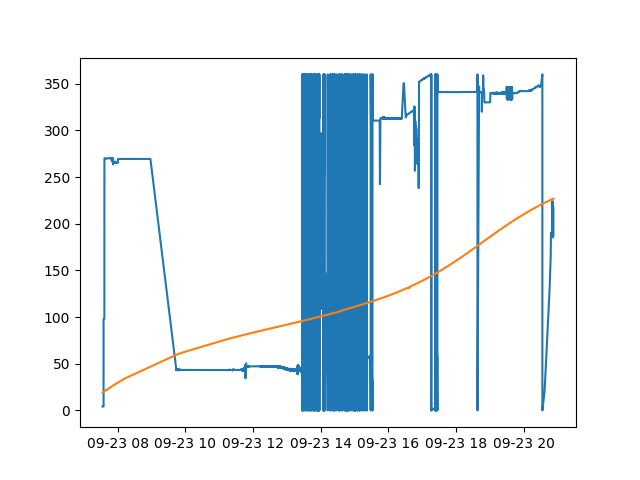

In [6]:
fig, ax = plt.subplots()
ax.plot(tm_az, az)
ax.plot(tm_az_sun, az_sun)

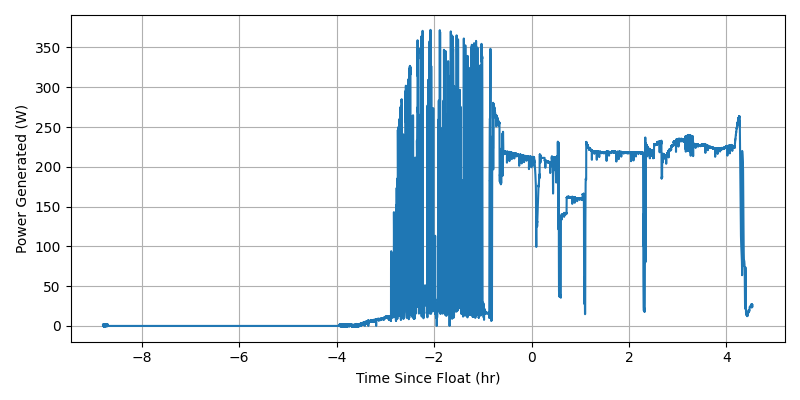

In [7]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_axisbelow(True)
ax.grid(True)
ax.plot([(t - FLOAT_TIME).total_seconds() / 3600. for t in tm_batt_i], power)
ax.set_xlabel('Time Since Float (hr)')
ax.set_ylabel ('Power Generated (W)')
fig.tight_layout()
fig.savefig('power_vs_time.png')

(-1.1848611111111744, 372.09170833335764)

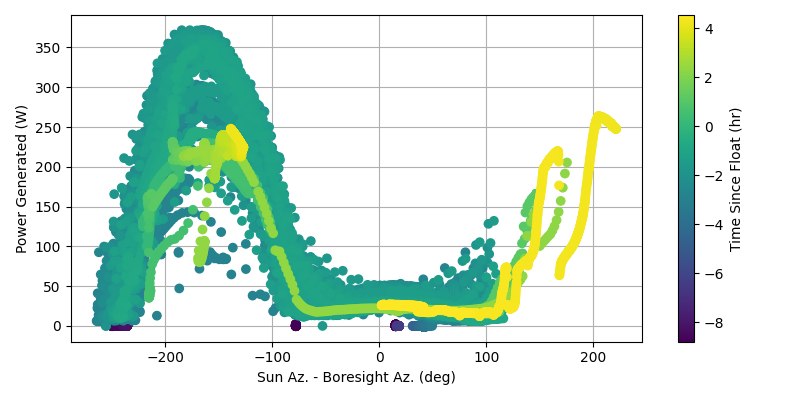

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_axisbelow(True)
ax.grid(True)
mappable = ax.scatter(
    az_sun[::5] - az[::200],
    power,
    c=[(t - FLOAT_TIME).total_seconds() / 3600. for t in tm_batt_i],
    # alpha=0.3,
    cmap='viridis'
)
fig.colorbar(mappable, ax=ax, label='Time Since Float (hr)')
x_range = np.arange(-240, 300, 30)
# ax.set_xlim(x_range[0], x_range[1])
# ax.set_xticks(x_range, labels=x_range, rotation=45);
ax.set_xlabel('Sun Az. - Boresight Az. (deg)')
ax.set_ylabel('Power Generated (W)')
fig.tight_layout()
fig.savefig('power_vs_solar_az.png', dpi=150)

power.min(), power.max()

In [16]:
current_keys = {
    'current_fc1': 12,
    'current_fc2': 12,
    'current_gyros_mags': 12,
    'current_sc1': 12,
    'current_sc2': 12,
    'current_gps': 5,
    'current_gondola_thermometry': 5,
    'current_rw_mc': 48,
    'current_el_mc': 28,
    'current_piv_mc': 28,
    'current_of_eth_ecat_sw': 28,
    'current_if_eth_sw': 28,
    'current_hdd': 28,
    'current_act_bus': 28,
    'current_pss': 28,
    'current_incs': 12,
    'current_watchdog': 12
}

def lincom(x, m, b):
    # These channels were overlooked in derived.c for test flight telemetry, so must do conversion here.
    return m * x + b

current_keys = {f"b'{item.upper()}'": voltage for item, voltage in current_keys.items()}
print(current_keys)

total_watts = 0
for key, voltage in current_keys.items():
    _, current_data_units = get_timeseries(GSE_TELEMETRY, key, 1.0)
    current = lincom(current_data_units, 5, -2.5)
    watts = np.abs(current).mean() * voltage
    total_watts += watts
    print(key, f'Mean: {current.mean():.3f} A,', f'Mean: {watts:.3f} W,', f'Max: {current.max():.3f} A,', f'Max: {np.abs(current).max() * voltage:.3f} W')
    print('| ' + ' | '.join([f'{current.mean():.3f}', f'{watts:.3f}', f'{current.max():.3f}', f'{np.abs(current).max() * voltage:.3f}']) + ' |')
print(total_watts)

{"b'CURRENT_FC1'": 12, "b'CURRENT_FC2'": 12, "b'CURRENT_GYROS_MAGS'": 12, "b'CURRENT_SC1'": 12, "b'CURRENT_SC2'": 12, "b'CURRENT_GPS'": 5, "b'CURRENT_GONDOLA_THERMOMETRY'": 5, "b'CURRENT_RW_MC'": 48, "b'CURRENT_EL_MC'": 28, "b'CURRENT_PIV_MC'": 28, "b'CURRENT_OF_ETH_ECAT_SW'": 28, "b'CURRENT_IF_ETH_SW'": 28, "b'CURRENT_HDD'": 28, "b'CURRENT_ACT_BUS'": 28, "b'CURRENT_PSS'": 28, "b'CURRENT_INCS'": 12, "b'CURRENT_WATCHDOG'": 12}


/tmp/ipykernel_112121/1741987711.py:20: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  t_raw = np.array(data["b'Time'"])
/tmp/ipykernel_112121/1741987711.py:25: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return tm, np.asarray(data[field])


b'CURRENT_FC1' Mean: 2.224 A, Mean: 26.691 W, Max: 4.795 A, Max: 57.538 W
| 2.224 | 26.691 | 4.795 | 57.538 |
b'CURRENT_FC2' Mean: 2.278 A, Mean: 27.337 W, Max: 5.262 A, Max: 63.143 W
| 2.278 | 27.337 | 5.262 | 63.143 |
b'CURRENT_GYROS_MAGS' Mean: 2.018 A, Mean: 24.218 W, Max: 4.394 A, Max: 52.729 W
| 2.018 | 24.218 | 4.394 | 52.729 |
b'CURRENT_SC1' Mean: 2.234 A, Mean: 26.817 W, Max: 5.421 A, Max: 65.055 W
| 2.234 | 26.817 | 5.421 | 65.055 |
b'CURRENT_SC2' Mean: 2.057 A, Mean: 24.695 W, Max: 4.561 A, Max: 54.736 W
| 2.057 | 24.695 | 4.561 | 54.736 |
b'CURRENT_GPS' Mean: 1.401 A, Mean: 7.006 W, Max: 4.039 A, Max: 20.196 W
| 1.401 | 7.006 | 4.039 | 20.196 |
b'CURRENT_GONDOLA_THERMOMETRY' Mean: 0.690 A, Mean: 3.466 W, Max: 3.462 A, Max: 17.308 W
| 0.690 | 3.466 | 3.462 | 17.308 |
b'CURRENT_RW_MC' Mean: 0.582 A, Mean: 29.544 W, Max: 11.674 A, Max: 560.347 W
| 0.582 | 29.544 | 11.674 | 560.347 |
b'CURRENT_EL_MC' Mean: 0.414 A, Mean: 12.217 W, Max: 3.010 A, Max: 84.292 W
| 0.414 | 12.217 | 

In [10]:
_, rw_current_read = get_timeseries(GSE_TELEMETRY, "b'MC_RW_I_READ'", 200.0)
_, piv_current_read = get_timeseries(GSE_TELEMETRY, "b'MC_PIV_I_READ'", 200.0)
_, el_current_read = get_timeseries(GSE_TELEMETRY, "b'MC_EL_I_READ'", 200.0)

/tmp/ipykernel_112121/1741987711.py:20: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  t_raw = np.array(data["b'Time'"])
/tmp/ipykernel_112121/1741987711.py:25: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return tm, np.asarray(data[field])


In [11]:
mask = np.where(np.abs(rw_current_read) > 0.1)[0]
np.abs(rw_current_read[mask]).mean(), np.abs(rw_current_read[mask]).max(), np.abs(rw_current_read[mask]).mean() * 48, np.abs(rw_current_read[mask]).max() * 48

(1.6686171850714357, 14.86, 80.09362488342892, 713.28)

In [12]:
mask = np.where(np.abs(rw_current_read) > 0.1)[0]
np.abs(piv_current_read[mask]).mean(), np.abs(piv_current_read[mask]).max(), np.abs(piv_current_read[mask]).mean() * 28, np.abs(piv_current_read[mask]).max() * 28

(5.2371658275714, 15.1, 146.6406431719992, 422.8)

In [13]:
np.abs(el_current_read[mask]).mean(), np.abs(el_current_read[mask]).max(), np.abs(el_current_read[mask]).mean() * 28, np.abs(el_current_read[mask]).max() * 28

(0.4641169939314053, 5.48, 12.995275830079349, 153.44)